In [1]:
import numpy as np
from numpy import savetxt
import pandas as pd
import matplotlib.pyplot as plt
import time
from tqdm.notebook import tqdm
import sys

# gensim for pretrained embedding
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.test.utils import datapath, get_tmpfile


# pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils import data
from torch.autograd import Variable

# torchtext
import torchtext.vocab as vocab


from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
print (torch.cuda.is_available())
print (torch.cuda.current_device())
print (torch.cuda.get_device_name(0))
print (torch.cuda.memory_allocated())
print (torch.cuda.memory_cached())

True
0
GeForce GTX 1060 with Max-Q Design
0
0


In [3]:
df = pd.read_csv("data/cleaned_amzn_data_4-15_10Kwords.csv", encoding='utf8', index_col=0)

In [4]:
drop_cols = ['review', 'cleaned_reviews']

try:
    df.drop(drop_cols, axis=1, inplace=True)
except:
    print ("Probably dropped already")
df = df.rename(columns={'overall': 'recommendation'})
df.head()

,recommendation,encoded_1,encoded_2,encoded_3,encoded_4,encoded_5,encoded_6,encoded_7,encoded_8,encoded_9,...,encoded_185,encoded_186,encoded_187,encoded_188,encoded_189,encoded_190,encoded_191,encoded_192,encoded_193,encoded_194
0,0,0,0,0,0,0,0,0,0,0,...,4059,9289,8594,9289,4934,7474,3382,652,2097,2876
1,1,0,0,0,0,0,0,0,0,0,...,3340,8561,9289,214,5126,6257,2827,6823,1256,8798
2,0,0,0,0,0,0,0,0,0,0,...,1745,5242,506,2434,7599,8764,5242,7146,6949,3506
4,1,0,0,0,0,0,0,0,0,0,...,7514,5853,5815,9606,595,8561,243,2076,2734,9289
5,1,0,0,0,0,0,0,0,0,0,...,8375,3595,1356,2298,8561,7502,2298,1329,6555,6758


# Load pretrained embedding

In [5]:
# google word2vec embedding #
# embed_path = 'data/GoogleNews-vectors-negative300.bin.gz'
# word2vec = KeyedVectors.load_word2vec_format(embed_path, binary=True)
# weights = word2vec.wv.vectors
# weights


# glove embedding #
glove_input_file = 'data/glove.6b/glove.6B.100d.txt'
word2vec_output_file = 'data/glove_to_word2vec.txt'

try:
    pretrained_embedding = KeyedVectors.load_word2vec_format(word2vec_output_file, binary=False)
except:
    print ("Converting word2vec file. If this fails, please download the glove.6b.100d file")
    glove2word2vec(glove_input_file, word2vec_output_file)

In [6]:
weights = pretrained_embedding.wv.vectors
pretrained_embedding.wv.vectors.shape

C:\Users\kevin\Anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.
C:\Users\kevin\Anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  


(400000, 100)

In [7]:
MAX_SEQ_LEN = len(df.columns.tolist())-1
VOCAB_SIZE = 14845 # 10746 - but need to use max(amzn_vocab, steam_vocab)
EMBED_DIM = 100
LSTM_DIM = 64

In [8]:
# only need 2-3 lines for attention
class Attention(nn.Module):
    def __init__(self, feature_dim, step_dim, bias=True, **kwargs):
        super(Attention, self).__init__(**kwargs)
        
        self.supports_masking = True

        self.bias = bias
        self.feature_dim = feature_dim
        self.step_dim = step_dim
        self.features_dim = 0
        
        weight = torch.zeros(feature_dim, 1)
        nn.init.kaiming_uniform_(weight)
        self.weight = nn.Parameter(weight)
        
        if bias:
            self.b = nn.Parameter(torch.zeros(step_dim))
    
    def forward(self, x, mask=None):
        feature_dim = self.feature_dim 
        step_dim = self.step_dim

        eij = torch.mm(
            x.contiguous().view(-1, feature_dim), 
            self.weight
        ).view(-1, step_dim)
        
        if self.bias:
            eij = eij + self.b
            
        eij = torch.tanh(eij)
        a = torch.exp(eij)
        
        if mask is not None:
            a = a * mask

        a = a / (torch.sum(a, 1, keepdim=True) + 1e-10)

        weighted_input = x * torch.unsqueeze(a, -1)
        return torch.sum(weighted_input, 1)

In [9]:
# build pytorch model
DROPOUT = 0.1
BATCH_SIZE = 128

class Attention_Net(nn.Module):
    def __init__(self):
        super(Attention_Net, self).__init__()
        
        # define architecture
        # self.embedding = nn.Embedding(VOCAB_SIZE, EMBED_DIM) # add pretrained embeding
        weights_ = Variable(torch.from_numpy(weights))
        print (weights_.size())
        self.embedding = nn.Embedding.from_pretrained(weights_)
    
        self.lstm = nn.LSTM(EMBED_DIM, 
                            LSTM_DIM, 
                            bidirectional=True,
                            dropout=0.2,
                            batch_first=True)
        
        # attention layer
        self.attention_layer = Attention(LSTM_DIM * 2, MAX_SEQ_LEN)
        # try tanh
        self.tanh = nn.Tanh()

        self.linear = nn.Linear(LSTM_DIM*2, 2)
        
    def forward(self, x):
        embedding = self.embedding(x)
        embedding = torch.squeeze(torch.unsqueeze(embedding, 0)).view(BATCH_SIZE, MAX_SEQ_LEN, -1)
        lstm_out, (hidden, cell) = self.lstm(embedding)
        attention = self.attention_layer(lstm_out)
        tanh = self.tanh(attention)
        
        # out = self.linear(lstm_out[:, -1, :])
        out = self.linear(tanh)
        return out

In [10]:
class AmznDataset(data.Dataset):
    def __init__(self, data):
        #'Initialization'
        self.data = data
        text_cols = [x for x in df.columns.tolist() if x.startswith("encoded")]
        self.train = torch.tensor(data[text_cols].values).type(torch.LongTensor).cuda()
        labels = data['recommendation'].tolist()
        
        self.one_hot_labels = torch.tensor(np.array(labels)).squeeze().type(torch.LongTensor).cuda() # change to longtensor if using custom loss
        

    def __len__(self):
        #'Denotes the total number of samples'
        return len(self.data)

    def __getitem__(self, index):
        #'Generates one sample of data'
        
        # Load data and get label
        X = self.train[index]
        Y = self.one_hot_labels[index]
        return X, Y

In [11]:
train_num = int(0.8 * len(df))
amzn_dataset = AmznDataset(df[:train_num])
amzn_data_loader = data.DataLoader(amzn_dataset, batch_size=BATCH_SIZE, num_workers=0, drop_last=True, shuffle=True)
amzn_data_loader

In [12]:
PATH = 'models/transfer_learning_grid_search_date4-21_batch64_epoch20_lstm64_lr0.0001.pt'
attention_model = Attention_Net().cuda()
attention_model.load_state_dict(torch.load(PATH))
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(attention_model.parameters(), lr=0.0001) # even lower for transfer learning

torch.Size([400000, 100])


C:\Users\kevin\Anaconda3\envs\pytorch\lib\site-packages\torch\nn\modules\rnn.py:51: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [18]:
# training loop
EPOCHS = 50
start = time.time()

for i in range(EPOCHS):
    second_start = time.time()
    running_loss = 0
    correct = 0
    attention_model.train()
    
    with tqdm(total=len(amzn_data_loader), file=sys.stdout) as pbar:
        for idx, (train_X, train_Y) in enumerate(amzn_data_loader):
            
            optimizer.zero_grad()

            pred_y = attention_model(train_X) 
            loss = loss_function(pred_y, train_Y)
            loss.backward()
            optimizer.step()
            running_loss += loss

#             # calc accuracy
#             pred1_mask = pred_y[:, 1] > 0.5
#             masked_trainY_1 = train_Y[pred1_mask]
#             masked_trainY_0 = train_Y[~pred1_mask]
#             ones_predicted_correct = torch.sum(masked_trainY_1)
#             zeros_predicted_correct = torch.sum(masked_trainY_0)
#             correct += ones_predicted_correct.add(zeros_predicted_correct)
#             correct_ = correct.cpu().numpy()
            
            # update progress bar
            pbar.set_description('ep{} | loss: {}'.format(i+1, torch.round(running_loss)))
            pbar.update(1)
            tqdm._instances.clear()
            
            

    print ('Epoch {} | took {} seconds | summed loss: {} | avg loss: {}'
                   .format(i+1, time.time() - second_start, running_loss, running_loss / (len(amzn_data_loader) * BATCH_SIZE)))

print ("Took {} seconds".format(time.time() - start))


Epoch 1 | took 31.955920934677124 seconds | summed loss: 664.375 | avg loss: 0.004286069422960281



Epoch 2 | took 32.298020362854004 seconds | summed loss: 628.521484375 | avg loss: 0.00405476801097393



Epoch 3 | took 32.06784248352051 seconds | summed loss: 636.7012939453125 | avg loss: 0.004107538610696793



Epoch 4 | took 30.259052991867065 seconds | summed loss: 620.909912109375 | avg loss: 0.004005663562566042



Epoch 5 | took 31.08240842819214 seconds | summed loss: 589.3091430664062 | avg loss: 0.0038017984479665756



Epoch 6 | took 32.44665288925171 seconds | summed loss: 605.0374145507812 | avg loss: 0.0039032658096402884



Epoch 7 | took 33.25549793243408 seconds | summed loss: 589.796142578125 | avg loss: 0.0038049400318413973



Epoch 8 | took 30.842018365859985 seconds | summed loss: 547.5619506835938 | avg loss: 0.003532475559040904



Epoch 9 | took 30.231225728988647 seconds | summed loss: 530.1354370117188 | avg loss: 0.003420052118599415



Epoch 10 | took 30.7870934009552 seconds | summed loss: 518.5615844726562 | avg loss: 0.0033453861251473427



Epoch 11 | took 30.622344732284546 seconds | summed loss: 506.83294677734375 | avg loss: 0.0032697212882339954



Epoch 12 | took 31.522379398345947 seconds | summed loss: 496.6298828125 | avg loss: 0.003203898435458541



Epoch 13 | took 31.04342532157898 seconds | summed loss: 487.7005615234375 | avg loss: 0.0031462928745895624



Epoch 14 | took 31.021822452545166 seconds | summed loss: 477.5454406738281 | avg loss: 0.003080779453739524



Epoch 15 | took 31.687747478485107 seconds | summed loss: 470.82568359375 | avg loss: 0.0030374284833669662



Epoch 16 | took 32.36628222465515 seconds | summed loss: 461.84454345703125 | avg loss: 0.002979488577693701



Epoch 17 | took 31.23593831062317 seconds | summed loss: 456.5172424316406 | avg loss: 0.0029451206792145967



Epoch 18 | took 32.00920844078064 seconds | summed loss: 450.1981506347656 | avg loss: 0.0029043543618172407



Epoch 19 | took 30.30433988571167 seconds | summed loss: 447.2314758300781 | avg loss: 0.002885215450078249



Epoch 20 | took 30.719604969024658 seconds | summed loss: 453.3872985839844 | avg loss: 0.002924928441643715



Epoch 21 | took 30.213740587234497 seconds | summed loss: 458.65179443359375 | avg loss: 0.002958891214802861



Epoch 22 | took 31.930519104003906 seconds | summed loss: 456.234375 | avg loss: 0.0029432957526296377



Epoch 23 | took 32.652260065078735 seconds | summed loss: 475.1128234863281 | avg loss: 0.003065085969865322



Epoch 24 | took 31.29687762260437 seconds | summed loss: 462.1648864746094 | avg loss: 0.0029815551824867725



Epoch 25 | took 31.559303760528564 seconds | summed loss: 456.5611877441406 | avg loss: 0.0029454040341079235



Epoch 26 | took 31.981529235839844 seconds | summed loss: 449.1151428222656 | avg loss: 0.0028973675798624754



Epoch 27 | took 31.190840005874634 seconds | summed loss: 438.2164306640625 | avg loss: 0.0028270569164305925



Epoch 28 | took 30.36350417137146 seconds | summed loss: 431.86456298828125 | avg loss: 0.002786079188808799



Epoch 29 | took 30.183255195617676 seconds | summed loss: 426.3968811035156 | avg loss: 0.002750805811956525



Epoch 30 | took 30.279892206192017 seconds | summed loss: 422.11376953125 | avg loss: 0.0027231741696596146



Epoch 31 | took 30.201569318771362 seconds | summed loss: 420.3201599121094 | avg loss: 0.002711603185161948



Epoch 32 | took 30.13690972328186 seconds | summed loss: 415.9920654296875 | avg loss: 0.002683681435883045



Epoch 33 | took 30.91925287246704 seconds | summed loss: 412.9969787597656 | avg loss: 0.002664359286427498



Epoch 34 | took 32.71621799468994 seconds | summed loss: 409.18756103515625 | avg loss: 0.0026397835463285446



Epoch 35 | took 31.347448110580444 seconds | summed loss: 406.78302001953125 | avg loss: 0.0026242712046951056



Epoch 36 | took 32.87962055206299 seconds | summed loss: 407.43963623046875 | avg loss: 0.002628507325425744



Epoch 37 | took 32.43954563140869 seconds | summed loss: 404.3952331542969 | avg loss: 0.002608866896480322



Epoch 38 | took 31.919511795043945 seconds | summed loss: 400.1571044921875 | avg loss: 0.002581525593996048



Epoch 39 | took 32.8369517326355 seconds | summed loss: 405.1568908691406 | avg loss: 0.002613780554383993



Epoch 40 | took 32.051061153411865 seconds | summed loss: 395.6037902832031 | avg loss: 0.002552150981500745



Epoch 41 | took 32.46633291244507 seconds | summed loss: 392.22052001953125 | avg loss: 0.0025303245056420565



Epoch 42 | took 33.003490924835205 seconds | summed loss: 393.4425964355469 | avg loss: 0.00253820838406682



Epoch 43 | took 33.17250394821167 seconds | summed loss: 389.65625 | avg loss: 0.0025137816555798054



Epoch 44 | took 33.953245639801025 seconds | summed loss: 388.61175537109375 | avg loss: 0.0025070433039218187



Epoch 45 | took 32.59829616546631 seconds | summed loss: 385.35552978515625 | avg loss: 0.002486036391928792



Epoch 46 | took 31.41478991508484 seconds | summed loss: 383.95184326171875 | avg loss: 0.002476980909705162



Epoch 47 | took 32.94311213493347 seconds | summed loss: 380.8553771972656 | avg loss: 0.002457004738971591



Epoch 48 | took 32.81839179992676 seconds | summed loss: 380.4909973144531 | avg loss: 0.0024546540807932615



Epoch 49 | took 32.081318855285645 seconds | summed loss: 384.564697265625 | avg loss: 0.0024809346068650484



Epoch 50 | took 32.867270946502686 seconds | summed loss: 406.4406433105469 | avg loss: 0.0026220623403787613
Took 1584.2290441989899 seconds


In [13]:
print (attention_model)

Attention_Net(
  (embedding): Embedding(400000, 100)
  (lstm): LSTM(100, 64, batch_first=True, dropout=0.2, bidirectional=True)
  (attention_layer): Attention()
  (tanh): Tanh()
  (linear): Linear(in_features=128, out_features=2, bias=True)
)


In [14]:
amzn_eval_dataset = AmznDataset(df[train_num:])
amzn_eval_data_loader = data.DataLoader(amzn_eval_dataset, batch_size=BATCH_SIZE, num_workers=0, drop_last=True)

In [15]:
# evaluate
correct = 0
eval_loss = 0
attention_model.eval()
with torch.no_grad():
    for i, (test_X, test_Y) in enumerate(amzn_eval_data_loader):
        preds = attention_model(test_X).squeeze()
        preds = torch.nn.functional.softmax(preds)
        for idx, each_pred in enumerate(preds):
            if each_pred[0] >= 0.5 and test_Y[idx] == 0:
                correct += 1
            elif each_pred[0] < 0.5 and test_Y[idx] == 1:
                correct += 1
        loss = loss_function(preds, test_Y)
        eval_loss += loss
        
        
print ("Eval accuracy: {}".format(correct / len(amzn_eval_dataset)))
print ("Eval summed loss: {} | avg loss: {}".format(eval_loss, eval_loss / len(amzn_eval_dataset)))

C:\Users\kevin\Anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


Eval accuracy: 0.4778210719170129
Eval summed loss: 238.1226348876953 | avg loss: 0.0061446246691048145


In [22]:
PATH = 'models/amzn_test_attention_transferlearning.pt'
torch.save(attention_model.state_dict(), PATH)

In [73]:
np.sum(df.recommendation.tolist()) / len(df)

0.7620507421399227

In [ ]:
# 77.8% eval acc -- batch=128, lr=0.0001
# 77.8% eval acc -- batch=128, lr=0.001
# 77.9% eval acc -- batch=64, lr=0.001, embed_dim=16, lstm_dim=16
# 85.9% eval acc -- batch=128, lr=0.0001, embed=128, lstm_dim=64
# 86.1% eval acc -- batch=128, lr=0.0001, embed=128, lstm_dim=64, + attention

# Graphs

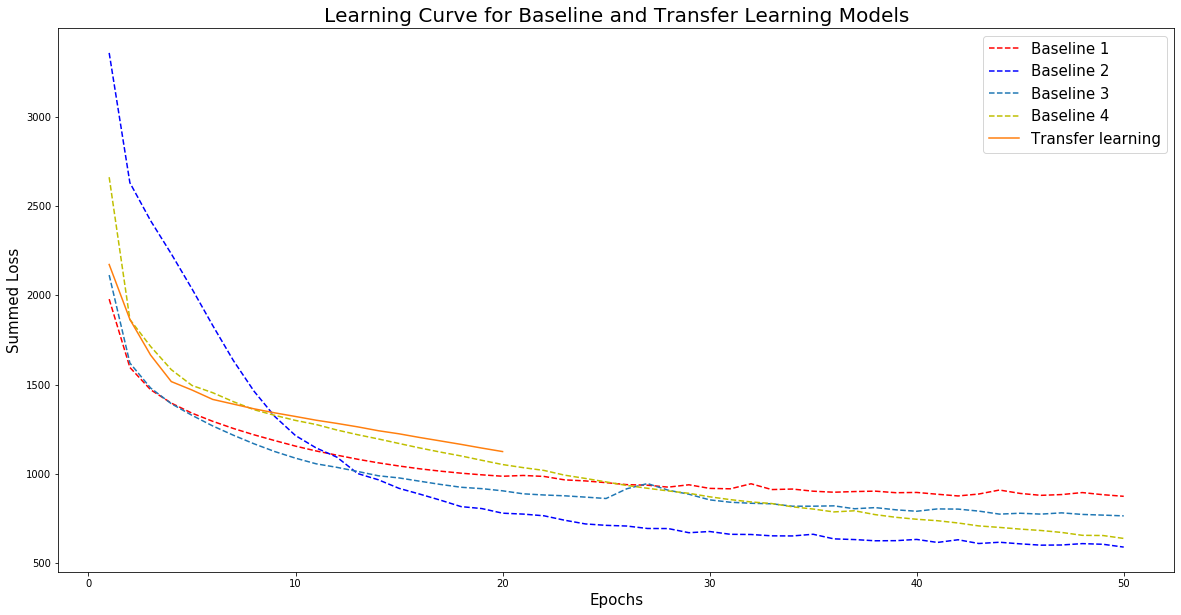

In [6]:
plt.figure(figsize=(20,10))

baseline1 = np.load('data/baseline_y_axis.npy') # batch 64
baseline2 = np.load('data/baseline2_y_axis.npy') # batch 64
baseline3 = np.load('data/baseline3_y_axis.npy') # batch 64
baseline4 = np.load('data/baseline4_y_axis.npy') # batch 64
prod = np.load('data/transferlearning_y_axis.npy') # batch 64

baseline_x = range(1, 51)
prod_x = range(1, 21)
plt.plot(baseline_x, baseline1, 'r--', label='Baseline 1')
plt.plot(baseline_x, baseline2*2, 'b--', label='Baseline 2')
plt.plot(baseline_x, baseline3, '--', label='Baseline 3')
plt.plot(baseline_x, baseline4, 'y--', label='Baseline 4')
plt.plot(prod_x, prod, label='Transfer learning')
plt.title("Learning Curve for Baseline and Transfer Learning Models", size=20)
plt.xlabel("Epochs", size=15)
plt.ylabel("Summed Loss", size=15)
plt.legend( prop={'size': 15})
plt.show()

In [ ]:
# transfer learning model got 47.7% on amazon model, forgot a lot!
# amazon model A, predict directly on steam dataset. Acc = 76.4%
# need confusion matrix